In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
j = lambda p, pp='..': os.path.join(pp, p) # shortcut for joining paths
m, p = u"\u208B", u"\u00B2" # unicode characters for subscript minus and superscript two

In [3]:
def project_dataframe(df_from, df_to, column_name):
    l_num, l_col, l_mae, l_mre = [], [], [], []
    for x in df_to['num_elements'].values:
        diffs = np.abs(x - df_from['num_elements'].values)
        idx = np.argmin(diffs)
        l_num.append(x)
        l_col.append(df_from[column_name].values[idx])
        l_mae.append(df_from['mae'].values[idx])
        l_mre.append(df_from['mre'].values[idx])
    return pd.DataFrame(list(zip(l_num, l_col, l_mae, l_mre)),
                        columns=['num_elements', column_name, 'mae', 'mre'])

In [4]:
def plot_dataframes(dfs, figw=18, figh=10.125, column_index=1):
    fig, ax = plt.subplots(1, 1, figsize=(figw, figh))
    for df in dfs:
        cdf = df.copy()
        cdf.iloc[:, column_index] = [ v/1024. for v in cdf.iloc[:, column_index] ]
        ax = cdf.plot(y=column_index, ax=ax)
    xi = list(range(len(dfs[0])))
    ax.set_xticks(xi)
    if column_index == 1:
        #ax.set_xticklabels([ str(2**(4+e)) for e in xi ], rotation=60);
        ax.set_xticklabels([ str(ne//1024) for ne in dfs[0]['num_elements'] ], rotation=60);
        ax.set_xlabel('Input size (KiS; S=float32)')
    elif column_index == 2:
        ax.set_xticklabels([ str(ne)+p for ne in dfs[0]['h'] ]);
        ax.set_xlabel('Input size (pixels)')
    ax.set_ylabel('Throughput (GiS/sec)')
    ax.grid(True, 'major', 'both', ls='--', lw=.5, c='k', alpha=.3)
    for s in ax.spines:
        ax.spines[s].set_linewidth(2)
    return fig, ax

In [5]:
base_dir = j('gpu_teslap100', j('results'))
d_1d_method_file_name = {
    'OA1D': 'alg3_fwd_rev.out',
    'CUB [4]': 'cub_fwd_rev.out',
    'PLR [25]': 'plr1_fwd_rev.out',
    'Alg3 [16]': 'alg3_1.out',
    'Memcpy': 'memcpy_fwd_rev.out',
    'OA1D'+m: 'alg3_step2_fwd_rev.out',
    'RD': 'alg_rd.out',
    'SMEM RD [20]': 'alg_smem_rd.out',
}
d_2d_method_file_name = {
    'OA2D': 'alg6i2_1.out',
    'OA2D'+m: 'alg6i1_1.out',
    'Alg6 [28]': 'alg6_1.out',
}
d_3d_method_file_name = {
    'OA3D': 'alg3_3d.out',
}

In [6]:
d_df_1d = {}
for method, file_name in d_1d_method_file_name.items():
    df = pd.read_csv(j(file_name, base_dir), header=None, sep=' ')
    if file_name == 'alg3_1.out':
        df.columns = ['w', 'h', method, 'mae', 'mre']
        df['num_elements'] = df['w'] * df['h']
    else:
        df.columns = ['num_elements', method, 'mae', 'mre']
    if df[method].isna().sum() > 0:
        df.fillna(method='ffill', inplace=True)
    d_df_1d[method] = df
d_df_1d['Alg3 [16]'] = project_dataframe(d_df_1d['Alg3 [16]'], d_df_1d['OA1D'], 'Alg3 [16]')

In [7]:
matplotlib.rcParams.update({'font.size': 14})

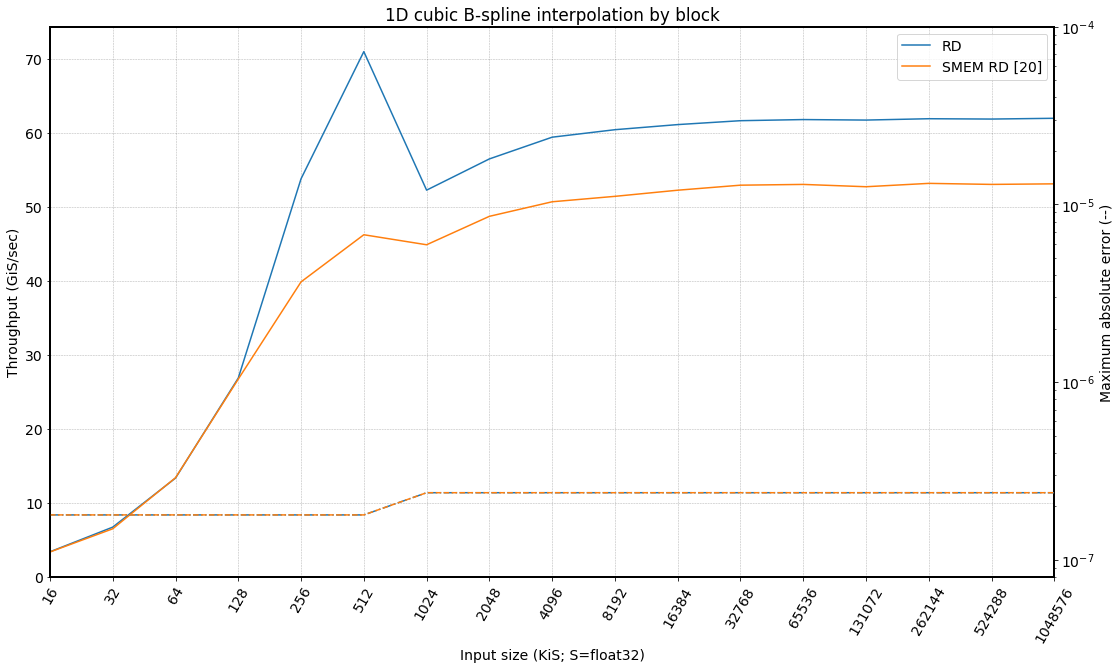

In [8]:
l_method = [ 'RD', 'SMEM RD [20]' ]
l_df = [ d_df_1d[m] for m in l_method ]
fig, ax = plot_dataframes(l_df)
ax.set_title('1D cubic B-spline interpolation by block')
ax2 = ax.twinx()
ax2.set_ylabel('Maximum absolute error (--)')
ax2.plot(d_df_1d['RD']['mae'], label='RD')
ax2.plot(d_df_1d['SMEM RD [20]']['mae'], label='SMEM RD [20]')
handles, labels = ax2.get_legend_handles_labels()
d_labels_handles = { label: handle for label, handle in zip(labels, handles) }
d_labels_handles['RD'].set_linestyle('-.')
d_labels_handles['SMEM RD [20]'].set_linestyle('--')
ax2.set_yscale('log')
ax2.set_ylim((8e-8, 1e-4))
fig.savefig('../paper/res1.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

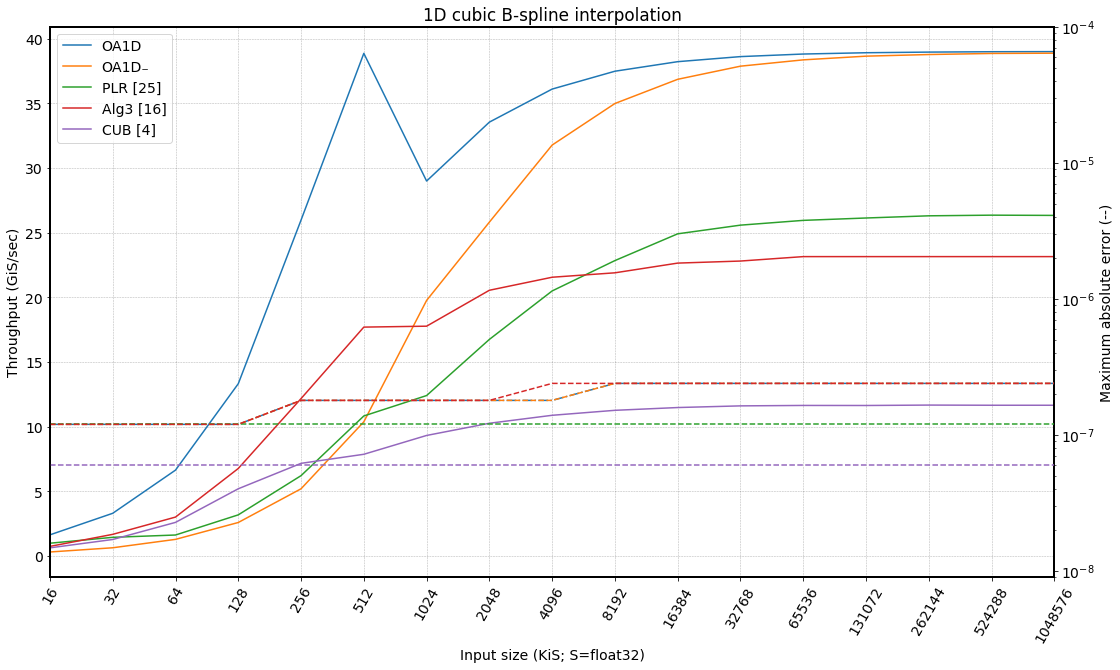

In [9]:
l_method = [ 'OA1D', 'OA1D'+m, 'PLR [25]', 'Alg3 [16]', 'CUB [4]' ]
l_df = [ d_df_1d[m] for m in l_method ]
fig, ax = plot_dataframes(l_df)
ax.set_title('1D cubic B-spline interpolation')
ax2 = ax.twinx()
ax2.set_ylabel('Maximum absolute error (--)')
ax2.plot(d_df_1d['OA1D']['mae'], label='OA1D')
ax2.plot(d_df_1d['OA1D'+m]['mae'], label='OA1D'+m)
ax2.plot(d_df_1d['PLR [25]']['mae'], label='PLR [25]')
ax2.plot(d_df_1d['Alg3 [16]']['mae'], label='Alg3 [16]')
ax2.plot(d_df_1d['CUB [4]']['mae'], label='CUB [4]')
handles, labels = ax2.get_legend_handles_labels()
d_labels_handles = { label: handle for label, handle in zip(labels, handles) }
d_labels_handles['OA1D'].set_linestyle('-.')
d_labels_handles['OA1D'+m].set_linestyle('--')
d_labels_handles['PLR [25]'].set_linestyle('--')
d_labels_handles['Alg3 [16]'].set_linestyle('--')
d_labels_handles['CUB [4]'].set_linestyle('--')
ax2.set_yscale('log')
ax2.set_ylim((9e-9, 1e-4))
fig.savefig('../paper/res2.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

In [10]:
d_df_2d = {}
for method, file_name in d_2d_method_file_name.items():
    df = pd.read_csv(j(file_name, base_dir), header=None, sep=' ')
    df.columns = ['w', 'h', method, 'mae', 'mre']
    if df[method].isna().sum() > 0:
        df.fillna(method='ffill', inplace=True)
    d_df_2d[method] = df

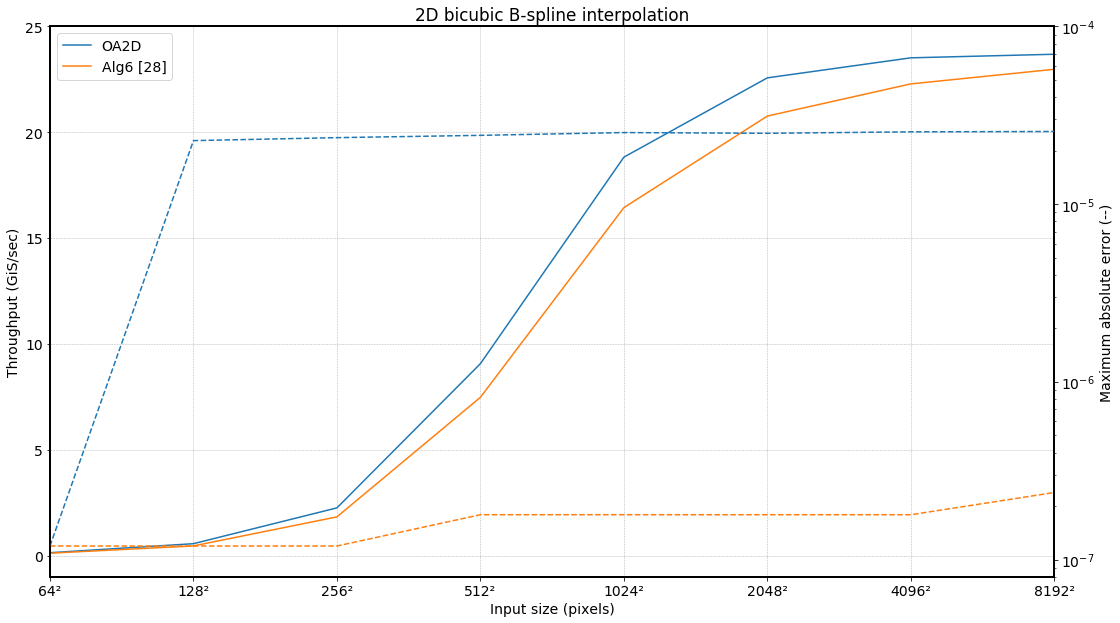

In [11]:
l_method = [ 'OA2D', 'Alg6 [28]' ]
l_df = [ d_df_2d[m] for m in l_method ]
#l_column = [ df.columns[2] for df in l_df ]
fig, ax = plot_dataframes(l_df, column_index=2)
ax.set_title('2D bicubic B-spline interpolation')
ax.set_ylim((-1, 25))
ax2 = ax.twinx()
ax2.set_ylabel('Maximum absolute error (--)')
ax2.plot(d_df_2d['OA2D']['mae'], label='OA2D')
ax2.plot(d_df_2d['Alg6 [28]']['mae'], label='Alg6 [28]')
handles, labels = ax2.get_legend_handles_labels()
d_labels_handles = { label: handle for label, handle in zip(labels, handles) }
d_labels_handles['OA2D'].set_linestyle('--')
d_labels_handles['Alg6 [28]'].set_linestyle('--')
ax2.set_yscale('log')
ax2.set_ylim((8e-8, 1e-4))
fig.savefig('../paper/res3.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

In [12]:
d_df_3d = {}
for method, file_name in d_3d_method_file_name.items():
    df = pd.read_csv(j(file_name, base_dir), header=None, sep=' ')
    df.columns = ['w', 'h', 'd', method, 'mae', 'mre']
    if df[method].isna().sum() > 0:
        df.fillna(method='ffill', inplace=True)
    d_df_3d[method] = df
d_df_3d['OA3D'] = d_df_3d['OA3D'].query('w == h')

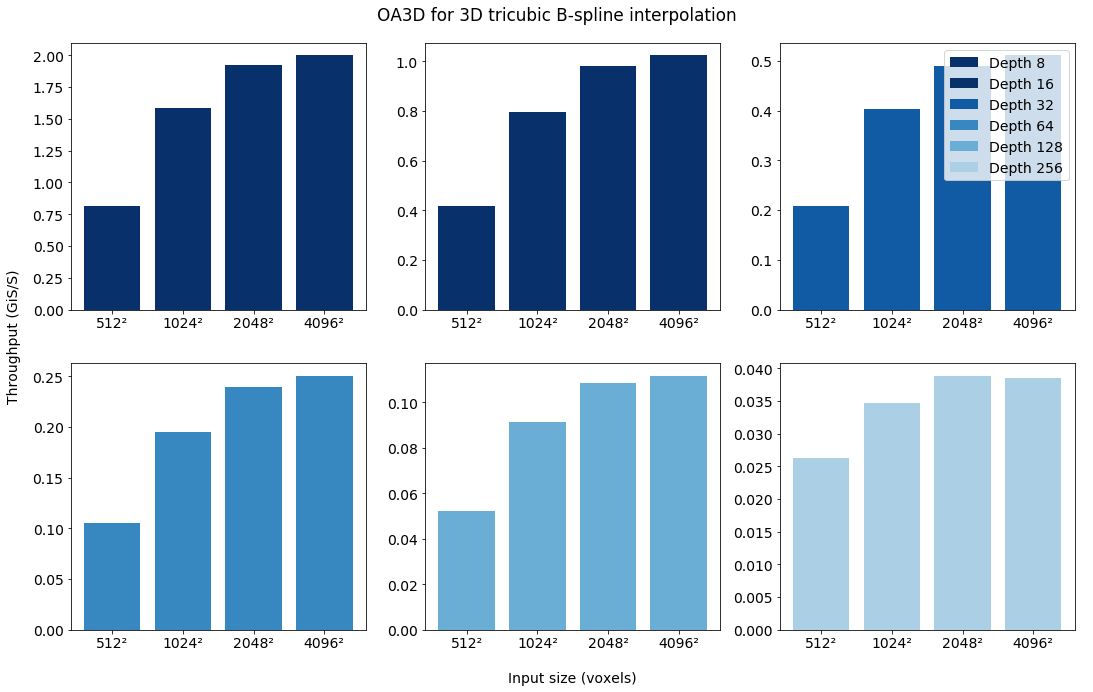

In [13]:
l_depths = d_df_3d['OA3D']['d'].unique().tolist()
n = len(l_depths)
n_rows = 2
n_cols = n // n_rows
fig, maxes = plt.subplots(n_rows, n_cols, figsize=(18, 10.125))
cmap = plt.get_cmap('Blues')
l_handles = []
for i, d in enumerate(l_depths):
    ii, jj = i // n_cols, i % n_cols
    a_whdv = d_df_3d['OA3D'].query(f'd == {d}').values
    l_x = [ f'{int(whdv[0])}'+p for whdv in a_whdv ]
    l_h = [ whdv[3]/1024. for whdv in a_whdv ]
    handle = maxes[ii, jj].bar(l_x, l_h, label=f'Depth {d}', color=cmap(((n-i+1)/n)))
    l_handles.append(handle)
fig.legend(l_handles, [ f'Depth {d}' for d in l_depths ], bbox_to_anchor=(0.83, 0.89))
ax = fig.add_subplot(111, frameon=False)
ax.tick_params(labelcolor="none", bottom=False, left=False, right=False, top=False)
ax.set_xlabel("\nInput size (voxels)")
ax.set_ylabel("Throughput (GiS/S)\n")
fig.suptitle('OA3D for 3D tricubic B-spline interpolation');
fig.subplots_adjust(top=0.93);
fig.savefig('../paper/res4.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

In [14]:
l_error_dimensions = [1, 1, 1, 1, 1, 1, 1, 2, 2, 3]
l_error_methods = ['OA1D', 'OA1D'+m, 'Alg3 [16]', 'PLR [25]', 'CUB [4]', 'RD', 'SMEM RD [20]', 'OA2D', 'Alg6 [28]', 'OA3D']
l_error_columns = [ 'Algorithm', 'Avg. Perf.', 'Avg. MAE', 'Avg. MRE', 'Dims.' ]
l_error = []
for i, method in enumerate(l_error_methods):
    df = {**d_df_1d, **d_df_2d, **d_df_3d}[method]
    row = (method, f'{df[method].mean()/1024.:.2f}', f'{df.mae.mean():.1e}', f'{df.mre.mean():.1e}', l_error_dimensions[i])
    l_error.append(row)
df_error = pd.DataFrame(l_error, columns=l_error_columns)

In [15]:
print(df_error.to_latex(index=False, column_format='c'*len(df_error.columns)))

\begin{tabular}{ccccc}
\toprule
    Algorithm & Avg. Perf. & Avg. MAE & Avg. MRE &  Dims. \\
\midrule
         OA1D &      29.27 &  1.9e-07 &  3.5e-07 &      1 \\
        OA1D₋ &      23.60 &  1.9e-07 &  3.5e-07 &      1 \\
    Alg3 [16] &      16.78 &  2.0e-07 &  3.4e-07 &      1 \\
     PLR [25] &      16.38 &  1.2e-07 &  2.2e-06 &      1 \\
      CUB [4] &       8.71 &  6.0e-08 &  1.0e-07 &      1 \\
           RD &      49.13 &  2.2e-07 &  4.4e-07 &      1 \\
 SMEM RD [20] &      41.26 &  2.2e-07 &  4.4e-07 &      1 \\
         OA2D &      12.58 &  2.2e-05 &  4.7e-05 &      2 \\
    Alg6 [28] &      11.54 &  1.6e-07 &  3.3e-07 &      2 \\
         OA3D &       0.52 &  1.9e-07 &  4.4e-07 &      3 \\
\bottomrule
\end{tabular}



----
# Not used
----

In [ ]:
#!inkscape res1.svg --export-pdf=../paper/res1.pdf

In [ ]:
#!inkscape res2.svg --export-pdf=../paper/res2.pdf

In [ ]:
#!inkscape res3.svg --export-pdf=../paper/res3.pdf

In [ ]:
#!inkscape res4.svg --export-pdf=../paper/res4.pdf

In [ ]:
from collections import OrderedDict

In [ ]:
#rd = '..' # root dir
#
#fp = os.path.join(rd, 'PLRresults-Andre.xlsx')
#df_plr_fig1 = pd.read_excel(fp, header=1, index_col=1, sheet_name='Figure1')
#df_plr_fig6 = pd.read_excel(fp, header=1, index_col=1, sheet_name='Figure6')
#df_plr_rf = pd.DataFrame({ 'num_elements': df_plr_fig6.index, 'PLR': df_plr_fig6['PLR'].values*(10**9/(2**30)) })
#df_memcpy_rf = pd.DataFrame({ 'num_elements': df_plr_fig6.index, 'memcpy': df_plr_fig6['memcpy'].values*(10**9/(2**30)) })
#plot_dataframes(l_df_rf[3:6] + [df_plr_rf, df_memcpy_rf])
#
#l_results_dir = [ p for p in os.listdir(rd) if os.path.isdir(j(p)) and 'results' in p ]
#l_fns = [ j(fn, j(d)) for d in l_results_dir for fn in os.listdir(j(d)) ]
#orig_alg3_fp = [ fn for fn in l_fns if 'alg3_1_orig_fwd_rev.out' in fn ][0]

#d = j('gpu_gtx1080', j('results'))
#l_fns = [ j(fn, d) for fn in os.listdir(d) ]

#l_df = [ pd.read_csv(fn, header=None, sep=' ',
#                     names=['num_elements', os.path.basename(fn)[:-4], 'mae', 'mre'])
#        for fn in l_fns ]
#l_df_fr = [ df for df in l_df if 'fwd_rev' in df.columns[1] ]
#l_df_rf = [ df for df in l_df if 'fwd_rf' in df.columns[1] ]
#l_df_ps = [ df for df in l_df if 'fwd_ps' in df.columns[1] ]
#l_df_3d = [ df for df in l_df if '3d' in df.columns[1] ]

#l_df_ps = l_df_ps[:2] + [l_df_ps[3]] + l_df_ps[4:] + [l_df_ps[2]]

In [ ]:
other_dir = j('gpu_gtx1080', j('results'))
d_ps_method_file_name = {
    'OA1D': 'alg3_fwd_ps.out',
    'CUB [4]': 'cub_fwd_ps.out',
    'PLR [25]': 'plr1_fwd_ps.out',
    'Memcpy': 'memcpy_fwd_ps.out',
    'Thrust [3]': 'thrust_fwd_ps.out',
    'SAM [24]': 'sam_fwd_ps.out',
}
d_ps_method_column_name = { k: v.split('.')[0] for k, v in d_ps_method_file_name.items() }

In [ ]:
d_df_ps = {}
for method, file_name in d_ps_method_file_name.items():
    column_name = d_ps_method_column_name[method]
    if file_name == 'sam_fwd_ps.out':
        df = pd.read_csv(j(file_name, other_dir), header=None, sep=' ')
    else:
        df = pd.read_csv(j(file_name, base_dir), header=None, sep=' ')
    df.columns = ['num_elements', column_name, 'mae', 'mre']
    if df[column_name].isna().sum() > 0:
        df.fillna(method='ffill', inplace=True)
    d_df_ps[method] = df

In [ ]:
l_method = [ 'OA1D', 'PLR [25]', 'CUB [4]', 'Thrust [3]', 'SAM [24]', 'Memcpy' ]
l_df = [ d_df_ps[m] for m in l_method ]
l_column = [ df.columns[1] for df in l_df ]
fig, ax = plot_dataframes(l_df)
ax.set_title('1D prefix sum')
handles, labels = ax.get_legend_handles_labels()
d_labels_handles = { label: handle for label, handle in zip(labels, handles) }
d_labels_handles['memcpy_fwd_ps'].set_linestyle('--')
d_labels_handles['memcpy_fwd_ps'].set_color('gray')
ax.legend([ d_labels_handles[c] for c in l_column], l_method)
c_int32, c_int64 = 'lightyellow', 'khaki'
l_rect = [
    patches.Rectangle((0, -2), 10, 2, facecolor=c_int32), patches.Rectangle((10, -2), 6, 2, facecolor=c_int64),
    patches.Rectangle((0, 0), 2, 2, facecolor=c_int32), patches.Rectangle((2, 0), 14, 2, facecolor=c_int64),
    patches.Rectangle((0, 2), 16, 2, facecolor=c_int64),
]
for rect in l_rect:
    ax.add_patch(rect)
d_bbox = dict(boxstyle='round', facecolor='none', alpha=0.3)
d_font = dict(size=14, color='black', family='serif')
ax.text(-1, 2.6, 'I: int32', fontdict=d_font, bbox=d_bbox)
ax.text(-1, 0.6, 'I: int16', fontdict=d_font, bbox=d_bbox)
ax.text(-1, -1.4, 'I: int8', fontdict=d_font, bbox=d_bbox)
ax.text(5-0.5, -1.5, 'O: int32', fontdict=d_font)
ax.text(13-0.5, -1.5, 'O: int64', fontdict=d_font)
ax.text(1-0.5, 0.5, 'O: int32', fontdict=d_font)
ax.text(9-0.5, 0.5, 'O: int64', fontdict=d_font)
ax.text(8-0.5, 2.5, 'O: int64', fontdict=d_font)
ax.text(12.4, 4.5, 'Requirements on Input/Output', fontdict=d_font, bbox=d_bbox)
ax.set_xlabel('Input size (KiS; S=int16|int32|int64)')
fig.savefig('res9.svg', format='svg')

In [ ]:
!inkscape res9.svg --export-pdf=../paper/res3.pdf

In [ ]:
d_bits_req = {8: [], 16: [], 32: [], 64: []}
for input_bits in d_bits_req:
    for l in range(14, 31):
        input_length = 2**l
        n_bits = math.ceil(math.log2((2**input_bits)*input_length))
        d_bits_req[input_bits].append(n_bits)

In [ ]:
d_bits_req

In [ ]:
dp = 'results20190801'
l_fp = [ j(fn, j(dp)) for fn in os.listdir(j(dp)) ]

In [ ]:
l_latest_df = [ pd.read_csv(fp, header=None, sep=' ', names=['num_elements', os.path.basename(fp)[:-4], 'mae', 'mre']) for fp in l_fp[1:] ]
l_latest_ps = [ df for df in l_latest_df if 'ps' in df.columns[1] ] + l_latest_df[5:6]
l_latest_rf = [ df for df in l_latest_df if 'fwd_rev' in df.columns[1] ]

In [ ]:
l_latest_rf[-2].iloc[-1,1:] = l_latest_rf[-2].iloc[-2,1:] # just repeat last row with values into last row with NaNs in CUB fwd+rev results

In [ ]:
df_Alg3 = pd.read_csv(l_fp[0], header=None, sep=' ', names=['w', 'h', 'Alg3', 'mae', 'mre'])
df_Alg3['num_elements'] = [ w*h for w, h in zip(df_Alg3['w'].values, df_Alg3['h'].values) ]
df_Alg3 = df_Alg3.drop('w', axis=1).drop('h', axis=1)
df_Alg3 = df_Alg3[df_Alg3.columns[-1:].tolist()+df_Alg3.columns[:-1].tolist()]
l_ids = l_latest_df[1]['num_elements'].values.tolist()
l_Alg3_ids = [ v for v in l_ids if v in df_Alg3['num_elements'].values ]
df_Alg3 = df_Alg3[df_Alg3['num_elements'].isin(l_Alg3_ids)]

In [ ]:
l_vals = []
for i in l_ids:
    if i in l_Alg3_ids:
        val = df_Alg3[df_Alg3['num_elements'] == i]['Alg3'].values[0]
    else:
        val = None
    l_vals.append(val)
for i, v in enumerate(l_vals):
    if v is None:
        if (i+1) < len(l_vals) and l_vals[i+1] is not None:
            l_vals[i] = (l_vals[i-1] + l_vals[i+1])/2.
        else:
            l_vals[i] = l_vals[i-1]

In [ ]:
df_Alg3 = pd.DataFrame(np.array([l_ids, l_vals]).transpose(), columns=['num_elements', 'Alg3'])
df_Alg3['num_elements'] = df_Alg3['num_elements'].values.astype(np.int64)

In [ ]:
plot_dataframes(l_latest_ps)

In [ ]:
plot_dataframes(l_latest_rf + [df_Alg3])

In [ ]:
for df_3d in l_df_3d:
    df_3d['total'] = [ (w*h*d) for (w, h), d in zip(df_3d.index, df_3d['num_elements']) ]
    df_3d['three_dim'] = [ (w,h,d) for (w, h), d in zip(df_3d.index, df_3d['num_elements']) ]

In [ ]:
df_3d = l_df_3d[1]
_, ax = plt.subplots(1, 1, figsize=(23, 7))
ax = df_3d.plot(x='three_dim', y='alg3_3d', kind='bar', ax=ax)
xi = df_3d['three_dim'].values
ax.set_xlabel('Samples ((w,h,d); s=float32)')
ax.set_ylabel('Throughput (Mis/s)')
ax.set_xticks(np.arange(len(df_3d)))
ax.set_xticklabels([ str(e) for e in xi ], rotation=60);
for tick in ax.get_xticklabels():
    tick.set_rotation(45)